# Noise Analysis

This notebook will try to analyse noise from real CT images to be able to reproduce it on synthetic images.

**Authors:** [Raphaël Achddou](https://people.epfl.ch/raphael.achddou) ([contact](mailto:raphael.achddou@epfl.ch)), [Paulo Ribeiro](https://people.epfl.ch/paulo.ribeirodecarvalho) ([contact](mailto:paulo.ribeirodecarvalho@epfl.ch))

## Import

In [1]:
from utils import load_data
from image_utils import utils, noise_analysis

%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# ~1min45s to load all 42'487 images
data_path = 'data'
data = load_data(data_path)

  0%|          | 0/33256 [00:00<?, ?it/s]

For computational purpose, we select a subset of the data to show results in the notebook.

In [3]:

# Let's only look at one specific patient for computation reasons
l506 = data.filter(cat=['train'],
                   img_type=['3mm B30'],
                   dose=['full', 'quarter'],
                   patient=['L506'])

# Separate full and quarter dose image of patient L506 for one specific conditions
l506_fd = l506.filter(dose=['full'])

l506_qd = l506.filter(dose=['quarter'])

## Basic Noise Analysis

Use the full and quarter dose projection, respectively FD and QD, to empirically compute the noise distribution. This way, we will be able to add some noise on our synthetic images to be able to train our model later on.

We will analyze the noise by level of grey, meaning that we compute the mean and standard deviation of a pixel value between its full and quarter dose image. Then, plot the standard deviation values by their grey level and compute the linear regression of all that. Then, intercept and slope will be our noise Poisson parameters.

Performing noise analysis in all image pair:   0%|          | 0/211 [00:00<?, ?it/s]

Computing mean variance, quantile of variances and density distributionfor all pixels intensities:   0%|      …

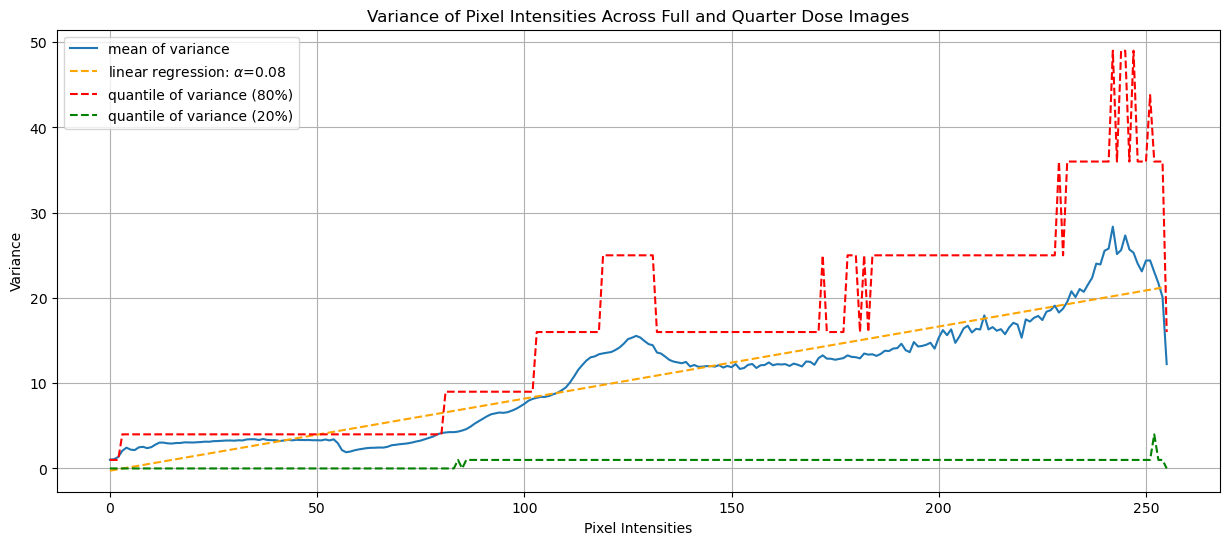

In [6]:
var_dict_mean, var_dict_q2, var_dict_q8, noise_density_distribution, slope = l506.noise_stat_analysis(plot=True)

## Advanced Noise Analysis

Since basic analysis have shown poor results, we performed a more advance noise analysis based on the following paper:

[1] *Realistic simulation of reduced-dose CT with noise modeling and sinogram synthesis using DICOM CT images*, Chang Won Kim & Jong Hyo Kim [(link)](https://aapm.onlinelibrary.wiley.com/doi/pdf/10.1118/1.4830431)